# MLPerf Models Inference Time Calculation

## Om Shri Prasath, EE17B113

> Note : Update pip!

In [42]:
!python3 -m pip install onnxruntime-gpu sacrebleu==1.2.10 mlperf-compliance==0.0.4 wandb Pillow matplotlib torch

     |████████████████████████████████| 1.8MB 10.8MB/s 
     |████████████████████████████████| 133kB 21.7MB/s 
     |████████████████████████████████| 163kB 35.0MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=c3df23c763aaa969f851b00e3d4d15038ed3625fdb339979580ae9cb8e0da2b8
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-1.0.1-cp36-none-any.whl size=72206 sha256=82090d6a418be5fa2eddf7479d13bdd9b8c0169399e7ff54815d71fbc64535bf
  Stored in directory: /root/.cache/pip/wheels/d8/ce/d8/31a48288b5728794feda5ac479fa324cc1cde4398c29eff064
Successfully built subprocess32 watchdog


In [2]:
import onnxruntime as rt
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import time

# Setting Up ONNX Backend

In [3]:
class Backend():
    def __init__(self):
        self.inputs = []
        self.outputs = []

    def version(self):
        raise NotImplementedError("Backend:version")

    def name(self):
        raise NotImplementedError("Backend:name")

    def load(self, model_path, inputs=None, outputs=None):
        raise NotImplementedError("Backend:load")

    def predict(self, feed):
        raise NotImplementedError("Backend:predict")

class BackendOnnxruntime(Backend):
    def __init__(self):
        super(BackendOnnxruntime, self).__init__()

    def version(self):
        return rt.__version__

    def name(self):
        """Name of the runtime."""
        return "onnxruntime"

    def image_format(self):
        """image_format. For onnx it is always NCHW."""
        return "NCHW"

    def load(self, model_path, inputs=None, outputs=None):
        """Load model and find input/outputs from the model file."""
        opt = rt.SessionOptions()
        # enable level 3 optimizations
        # FIXME: enable below once onnxruntime 0.5 is released
        # opt.set_graph_optimization_level(3)
        self.sess = rt.InferenceSession(model_path, opt)
        # get input and output names
        if not inputs:
            self.inputs = [meta.name for meta in self.sess.get_inputs()]
        else:
            self.inputs = inputs
        if not outputs:
            self.outputs = [meta.name for meta in self.sess.get_outputs()]
        else:
            self.outputs = outputs
        return self

    def predict(self, feed):
        """Run the prediction."""
        return self.sess.run(self.outputs, feed)

# Object Recognition

## Downloading the ImageNet dataset and classes

In [4]:
!git clone https://github.com/ajschumacher/imagen.git 
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
classes = json.load(open('imagenet-simple-labels.json','r'))
images_link = ['imagen/imagen/n02883205_14588_bow_tie.jpg',
 'imagen/imagen/n07697100_7092_hamburger.jpg',
 'imagen/imagen/n01982650_8073_lobster.jpg',
 'imagen/imagen/n04336792_7621_stretcher.jpg',
 'imagen/imagen/n03372029_37410_flute.jpg',
 'imagen/imagen/n02084071_19639_dog.jpg',
 'imagen/imagen/n01910747_3168_jellyfish.jpg',
 'imagen/imagen/n03950228_11894_pitcher.jpg',
 'imagen/imagen/n02764044_41120_axe.jpg',
 'imagen/imagen/n02391049_738_zebra.jpg',
 'imagen/imagen/n01990800_9645_isopod.jpg',
 'imagen/imagen/n04254120_3218_soap_dispenser.jpg',
 'imagen/imagen/n03394916_33902_french_horn.jpg',
 'imagen/imagen/n03838899_35609_oboe.jpg',
 'imagen/imagen/n02219486_28997_ant.jpg',
 'imagen/imagen/n04530566_23960_watercraft.jpg',
 'imagen/imagen/n02454379_6001_armadillo.jpg',
 'imagen/imagen/n02454379_10511_armadillo.jpg',
 'imagen/imagen/n02799071_7237_baseball.jpg',
 'imagen/imagen/n02129604_7642_tiger.jpg',
 'imagen/imagen/n02342885_4272_hamster.jpg',
 'imagen/imagen/n03710721_8217_maillot.jpg',
 'imagen/imagen/n02503517_12534_elephant.jpg',
 'imagen/imagen/n02395003_18939_swine.jpg',
 'imagen/imagen/n02970849_18467_cart.jpg',
 'imagen/imagen/n02892767_14415_brassiere.jpg',
 'imagen/imagen/n03124170_1539_hat_with_a_wide_brim.jpg',
 'imagen/imagen/n07734744_7971_mushroom.jpg',
 'imagen/imagen/n04004767_4972_printer.jpg',
 'imagen/imagen/n01882714_14215_koala_bear.jpg']

Cloning into 'imagen'...
remote: Enumerating objects: 1004, done.
remote: Total 1004 (delta 0), reused 0 (delta 0), pack-reused 1004
Receiving objects: 100% (1004/1004), 99.90 MiB | 22.90 MiB/s, done.
Resolving deltas: 100% (1/1), done.
--2020-12-11 15:08:02--  https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14193 (14K) [text/plain]
Saving to: ‘imagenet-simple-labels.json’

imagenet-simple-lab 100%[===================>]  13.86K  --.-KB/s    in 0s      

2020-12-11 15:08:03 (35.4 MB/s) - ‘imagenet-simple-labels.json’ saved [14193/14193]



## ResNet-v1.5

In [5]:
!wget https://zenodo.org/record/2592612/files/resnet50_v1.onnx

--2020-12-11 15:08:03--  https://zenodo.org/record/2592612/files/resnet50_v1.onnx
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102164585 (97M) [application/octet-stream]
Saving to: ‘resnet50_v1.onnx’

resnet50_v1.onnx    100%[===================>]  97.43M  51.8MB/s    in 1.9s    

2020-12-11 15:08:05 (51.8 MB/s) - ‘resnet50_v1.onnx’ saved [102164585/102164585]



In [6]:
bk_obj = BackendOnnxruntime()
bk_obj.load("./resnet50_v1.onnx")
input_name = bk_obj.sess.get_inputs()[0].name

In [7]:
preprocessed_images = []

for i in images_link:
  img = Image.open(i)
  resized_im = img.resize((224, 224))
  pre_img = np.array(resized_im).astype(np.float32)-127.5
  img_rolled = np.rollaxis(pre_img, 2, 0)
  preprocessed_images.append(img_rolled)

preprocessed_images = np.array(preprocessed_images)

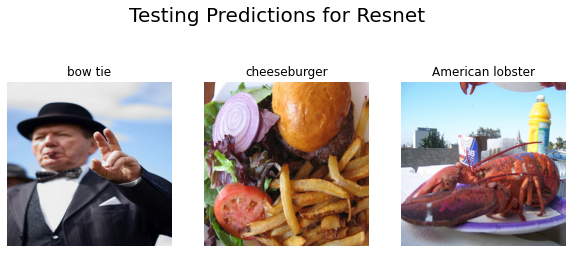

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
for i in range(3):
  plt.sca(axs.flatten()[i])
  pred = classes[bk_obj.predict({input_name:[preprocessed_images[i]]})[0][0]-1]
  plt.title(pred)
  plt.axis('off')
  plt.imshow(Image.open(images_link[i]).resize((224,224)))
plt.subplots_adjust(top=1.4)
plt.suptitle(u"Testing Predictions for Resnet",fontsize=20)
plt.show()

In [9]:
inference_times = []
for i in range(len(preprocessed_images)):
  start = time.process_time()
  bk_obj.predict({input_name:[preprocessed_images[i]]})
  inference_times.append(time.process_time() - start)

In [10]:
print("\033[1;30mInference Latency Test for ResNet :\033[0m\n")
for i in range(len(inference_times)):
  print("Inference Time for Iteration {:2d} = {:7.4f} ms".format(i+1,inference_times[i]*1000))

print("\nAverage Inference Time = {:.4f} ms".format(np.mean(inference_times)*1000))

Inference Latency Test for ResNet :

Inference Time for Iteration  1 = 20.0503 ms
Inference Time for Iteration  2 = 19.4759 ms
Inference Time for Iteration  3 = 16.2427 ms
Inference Time for Iteration  4 = 19.3536 ms
Inference Time for Iteration  5 = 19.3027 ms
Inference Time for Iteration  6 = 19.2665 ms
Inference Time for Iteration  7 = 17.6637 ms
Inference Time for Iteration  8 = 17.7801 ms
Inference Time for Iteration  9 = 17.7662 ms
Inference Time for Iteration 10 = 18.0353 ms
Inference Time for Iteration 11 = 17.8642 ms
Inference Time for Iteration 12 = 17.8063 ms
Inference Time for Iteration 13 = 17.6786 ms
Inference Time for Iteration 14 = 18.2056 ms
Inference Time for Iteration 15 = 16.2726 ms
Inference Time for Iteration 16 = 17.1318 ms
Inference Time for Iteration 17 = 16.2133 ms
Inference Time for Iteration 18 = 16.3657 ms
Inference Time for Iteration 19 = 16.2166 ms
Inference Time for Iteration 20 = 16.2335 ms
Inference Time for Iteration 21 = 16.1515 ms
Inference Time for

## Mobilenet-v1

In [11]:
!wget https://zenodo.org/record/3157894/files/mobilenet_v1_1.0_224.onnx

--2020-12-11 15:08:13--  https://zenodo.org/record/3157894/files/mobilenet_v1_1.0_224.onnx
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16983656 (16M) [application/octet-stream]
Saving to: ‘mobilenet_v1_1.0_224.onnx’

mobilenet_v1_1.0_22 100%[===================>]  16.20M  48.0MB/s    in 0.3s    

2020-12-11 15:08:14 (48.0 MB/s) - ‘mobilenet_v1_1.0_224.onnx’ saved [16983656/16983656]



In [12]:
bk_obj = BackendOnnxruntime()
bk_obj.load("./mobilenet_v1_1.0_224.onnx")
input_name = bk_obj.sess.get_inputs()[0].name

In [13]:
def _preprocess_input(img):
  img -= 127.5
  img /= 127.5
  return img

In [14]:
preprocessed_images = []

for i in images_link:
  img = Image.open(i)
  resized_im = img.resize((224, 224))
  pre_img = (np.array(resized_im).astype(np.float32))/127.5 - 1
  img_rolled = np.rollaxis(pre_img, 2, 0)
  preprocessed_images.append(img_rolled)

preprocessed_images = np.array(preprocessed_images)

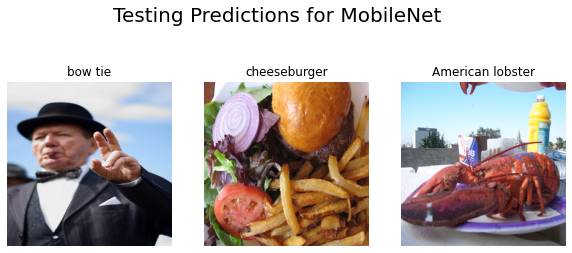

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
for i in range(3):
  plt.sca(axs.flatten()[i])
  pred = classes[np.argmax(bk_obj.predict({input_name:[preprocessed_images[i]]}))-1]
  plt.title(pred)
  plt.axis('off')
  plt.imshow(Image.open(images_link[i]).resize((224,224)))
plt.subplots_adjust(top=1.4)
plt.suptitle(u"Testing Predictions for MobileNet",fontsize=20)
plt.show()

In [16]:
inference_times = []
for i in range(len(preprocessed_images)):
  start = time.process_time()
  bk_obj.predict({input_name:[preprocessed_images[i]]})
  inference_times.append(time.process_time() - start)

In [17]:
print("\033[1;30mInference Latency Test for MobileNet :\033[0m\n")
for i in range(len(inference_times)):
  print("Inference Time for Iteration {:2d} = {:7.4f} ms".format(i+1,inference_times[i]*1000))

print("\nAverage Inference Time = {:.4f} ms".format(np.mean(inference_times)*1000))

Inference Latency Test for MobileNet :

Inference Time for Iteration  1 = 13.1121 ms
Inference Time for Iteration  2 = 12.7953 ms
Inference Time for Iteration  3 = 12.2298 ms
Inference Time for Iteration  4 = 10.3419 ms
Inference Time for Iteration  5 =  9.0794 ms
Inference Time for Iteration  6 =  9.0222 ms
Inference Time for Iteration  7 =  9.0062 ms
Inference Time for Iteration  8 =  8.9898 ms
Inference Time for Iteration  9 =  9.1926 ms
Inference Time for Iteration 10 =  8.9288 ms
Inference Time for Iteration 11 =  9.4580 ms
Inference Time for Iteration 12 =  9.2955 ms
Inference Time for Iteration 13 =  9.2899 ms
Inference Time for Iteration 14 =  9.4405 ms
Inference Time for Iteration 15 =  9.3861 ms
Inference Time for Iteration 16 =  9.9717 ms
Inference Time for Iteration 17 =  9.4872 ms
Inference Time for Iteration 18 =  9.8470 ms
Inference Time for Iteration 19 =  9.2713 ms
Inference Time for Iteration 20 =  9.0484 ms
Inference Time for Iteration 21 =  9.0970 ms
Inference Time 

# Object Detection

## Downloading COCO dataset and classes

In [18]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-2014_2017.txt
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
classes = np.array(['background']+open("./coco-labels-2014_2017.txt",'r').read().splitlines())
classes_old = np.array(['background']+open("./coco-labels-paper.txt",'r').read().splitlines())
images_link = ['val2017/000000002006.jpg', 'val2017/000000475572.jpg', 'val2017/000000138550.jpg', 'val2017/000000494863.jpg', 'val2017/000000433243.jpg', 'val2017/000000181499.jpg', 'val2017/000000482585.jpg', 'val2017/000000383621.jpg', 'val2017/000000293071.jpg', 'val2017/000000129062.jpg', 'val2017/000000400044.jpg', 'val2017/000000079651.jpg', 'val2017/000000408696.jpg', 'val2017/000000434247.jpg', 'val2017/000000430973.jpg', 'val2017/000000214720.jpg', 'val2017/000000230362.jpg', 'val2017/000000297147.jpg', 'val2017/000000177539.jpg', 'val2017/000000348012.jpg', 'val2017/000000259830.jpg', 'val2017/000000408774.jpg', 'val2017/000000242934.jpg', 'val2017/000000274411.jpg', 'val2017/000000455716.jpg', 'val2017/000000422706.jpg', 'val2017/000000343453.jpg', 'val2017/000000193926.jpg', 'val2017/000000200961.jpg', 'val2017/000000123131.jpg']

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/000000526751.jpg  
 extracting: val2017/000000041488.jpg  
 extracting: val2017/000000153632.jpg  
 extracting: val2017/000000501523.jpg  
 extracting: val2017/000000405691.jpg  
 extracting: val2017/000000040757.jpg  
 extracting: val2017/000000219485.jpg  
 extracting: val2017/000000428280.jpg  
 extracting: val2017/000000209222.jpg  
 extracting: val2017/000000353051.jpg  
 extracting: val2017/000000191471.jpg  
 extracting: val2017/000000539962.jpg  
 extracting: val2017/000000462371.jpg  
 extracting: val2017/000000574315.jpg  
 extracting: val2017/00000000

## SSD-ResNet34

In [19]:
!wget https://zenodo.org/record/3228411/files/resnet34-ssd1200.onnx

--2020-12-11 15:09:03--  https://zenodo.org/record/3228411/files/resnet34-ssd1200.onnx
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80363696 (77M) [application/octet-stream]
Saving to: ‘resnet34-ssd1200.onnx’

resnet34-ssd1200.on 100%[===================>]  76.64M  75.5MB/s    in 1.0s    

2020-12-11 15:09:05 (75.5 MB/s) - ‘resnet34-ssd1200.onnx’ saved [80363696/80363696]



In [20]:
bk_obj = BackendOnnxruntime()
bk_obj.load("./resnet34-ssd1200.onnx")
input_name = bk_obj.sess.get_inputs()[0].name

In [21]:
preprocessed_images = []

for i in images_link:
  img = Image.open(i)
  resized_im = img.resize((1200, 1200))
  pre_img = (np.array(resized_im).astype(np.float32))/127.5 - 1
  img_rolled = np.rollaxis(pre_img, 2, 0)
  preprocessed_images.append(img_rolled)

preprocessed_images = np.array(preprocessed_images)

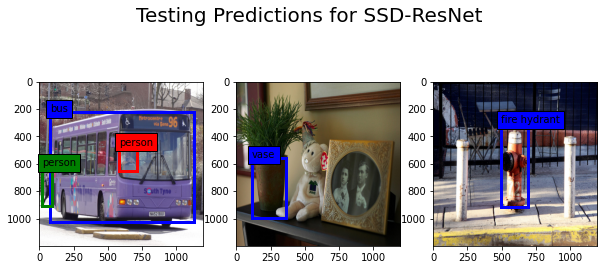

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
for i in range(3):
  bbox,cls,prob = bk_obj.predict({input_name:[preprocessed_images[i]]})
  its = (prob>0.5)

  bbox = bbox[its]
  cls = cls[its]
  prob = prob[its]

  ax = axs[i]

  ax.imshow(Image.open(images_link[i]).resize((1200,1200)))

  colors = ['b', 'g', 'r', 'c', 'm', 'y']

  for m,i in enumerate(bbox):
    c = m
    while(c>len(colors)):
      c = c-len(colors)
    left, bot, right, top = i
    x, y, w, h = [int(val * 1200) for val in [left, bot, right - left, top - bot]]
    rect = patches.Rectangle((x,y),w,h,linewidth=3,edgecolor=colors[c],facecolor='none')
    ax.text(x,y,classes[cls[c]],bbox=dict(facecolor=colors[c]))
    ax.add_patch(rect)

plt.subplots_adjust(top=1.4)
plt.suptitle(u"Testing Predictions for SSD-ResNet",fontsize=20)
plt.show()

In [23]:
inference_times = []
for i in range(len(preprocessed_images)):
  start = time.process_time()
  bk_obj.predict({input_name:[preprocessed_images[i]]})
  inference_times.append(time.process_time() - start)

In [24]:
print("\033[1;30mInference Latency Test for SSD-ResNet :\033[0m\n")
for i in range(len(inference_times)):
  print("Inference Time for Iteration {:2d} = {:7.4f} ms".format(i+1,inference_times[i]*1000))

print("\nAverage Inference Time = {:.4f} ms".format(np.mean(inference_times)*1000))

Inference Latency Test for SSD-ResNet :

Inference Time for Iteration  1 = 388.8601 ms
Inference Time for Iteration  2 = 324.4606 ms
Inference Time for Iteration  3 = 307.6675 ms
Inference Time for Iteration  4 = 311.4516 ms
Inference Time for Iteration  5 = 310.3811 ms
Inference Time for Iteration  6 = 311.7712 ms
Inference Time for Iteration  7 = 318.5078 ms
Inference Time for Iteration  8 = 314.8819 ms
Inference Time for Iteration  9 = 301.7639 ms
Inference Time for Iteration 10 = 308.7141 ms
Inference Time for Iteration 11 = 309.0767 ms
Inference Time for Iteration 12 = 310.3096 ms
Inference Time for Iteration 13 = 309.4812 ms
Inference Time for Iteration 14 = 307.2601 ms
Inference Time for Iteration 15 = 316.6408 ms
Inference Time for Iteration 16 = 325.4822 ms
Inference Time for Iteration 17 = 306.1994 ms
Inference Time for Iteration 18 = 312.4698 ms
Inference Time for Iteration 19 = 308.5100 ms
Inference Time for Iteration 20 = 311.2257 ms
Inference Time for Iteration 21 = 314.3

## SSD-MobileNet

In [25]:
!wget https://zenodo.org/record/3163026/files/ssd_mobilenet_v1_coco_2018_01_28.onnx

--2020-12-11 15:09:34--  https://zenodo.org/record/3163026/files/ssd_mobilenet_v1_coco_2018_01_28.onnx
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30053232 (29M) [application/octet-stream]
Saving to: ‘ssd_mobilenet_v1_coco_2018_01_28.onnx’

ssd_mobilenet_v1_co 100%[===================>]  28.66M  44.7MB/s    in 0.6s    

2020-12-11 15:09:35 (44.7 MB/s) - ‘ssd_mobilenet_v1_coco_2018_01_28.onnx’ saved [30053232/30053232]



In [26]:
bk_obj = BackendOnnxruntime()
bk_obj.load("./ssd_mobilenet_v1_coco_2018_01_28.onnx")
input_name = bk_obj.sess.get_inputs()[0].name

In [27]:
preprocessed_images = []

for i in images_link:
  img = Image.open(i)
  resized_im = img.resize((300, 300))
  pre_img = (np.array(resized_im).astype(np.float32))
  preprocessed_images.append(pre_img)

preprocessed_images = np.array(preprocessed_images)

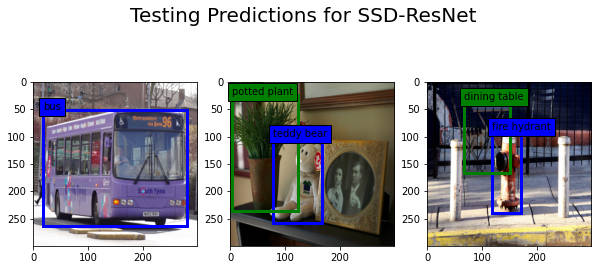

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
for i in range(3):
  n,bbox,prob,cls = bk_obj.predict({input_name:[preprocessed_images[i]]})
  its = ((prob>0.6) & (cls!=1))
  bbox = bbox[its]
  cls = cls[its].astype(np.int)
  prob = prob[its]

  ax = axs[i]

  ax.imshow(Image.open(images_link[i]).resize((300,300)))

  colors = ['b', 'g', 'r', 'c', 'm', 'y']

  for m,i in enumerate(bbox):
    c = m
    while(c>len(colors)):
      c = c-len(colors)
    left, bot, right, top = i
    x, y, w, h = [int(val * 300) for val in [left, bot, right - left, top - bot]]
    rect = patches.Rectangle((y,x),h,w,linewidth=3,edgecolor=colors[c],facecolor='none')
    ax.text(y,x,classes_old[cls[c]],bbox=dict(facecolor=colors[c]))
    ax.add_patch(rect)

plt.subplots_adjust(top=1.4)
plt.suptitle(u"Testing Predictions for SSD-ResNet",fontsize=20)
plt.show()

In [29]:
inference_times = []
for i in range(len(preprocessed_images)):
  start = time.process_time()
  bk_obj.predict({input_name:[preprocessed_images[i]]})
  inference_times.append(time.process_time() - start)

In [30]:
print("\033[1;30mInference Latency Test for SSD-MobileNet :\033[0m\n")
for i in range(len(inference_times)):
  print("Inference Time for Iteration {:2d} = {:7.4f} ms".format(i+1,inference_times[i]*1000))

print("\nAverage Inference Time = {:.4f} ms".format(np.mean(inference_times)*1000))

Inference Latency Test for SSD-MobileNet :

Inference Time for Iteration  1 = 88.2939 ms
Inference Time for Iteration  2 = 67.3143 ms
Inference Time for Iteration  3 = 64.0405 ms
Inference Time for Iteration  4 = 63.4844 ms
Inference Time for Iteration  5 = 63.6029 ms
Inference Time for Iteration  6 = 66.2433 ms
Inference Time for Iteration  7 = 70.1027 ms
Inference Time for Iteration  8 = 62.8897 ms
Inference Time for Iteration  9 = 62.8024 ms
Inference Time for Iteration 10 = 63.1230 ms
Inference Time for Iteration 11 = 63.4459 ms
Inference Time for Iteration 12 = 64.0125 ms
Inference Time for Iteration 13 = 63.9988 ms
Inference Time for Iteration 14 = 64.9287 ms
Inference Time for Iteration 15 = 64.0302 ms
Inference Time for Iteration 16 = 66.9473 ms
Inference Time for Iteration 17 = 66.6368 ms
Inference Time for Iteration 18 = 64.3285 ms
Inference Time for Iteration 19 = 64.3114 ms
Inference Time for Iteration 20 = 62.8166 ms
Inference Time for Iteration 21 = 63.2883 ms
Inference T

# Translation

In [31]:
texts = ["The truth is that you pay for your lifestyle in hours.","Whenever he saw a red flag warning at the beach he grabbed his surfboard.","He wondered if she would appreciate his toenail collection.","I really want to go to work, but I am too sick to drive.","Beach-combing replaced wine tasting as his new obsession.","The two walked down the slot canyon oblivious to the sound of thunder in the distance.","I'm confused: when people ask me what's up, and I point, they groan.","Swim at your own risk was taken as a challenge for the group of Kansas City college students.","He quietly entered the museum as the super bowl started.","It didn't take long for Gary to detect the robbers were amateurs.","It turns out you don't need all that stuff you insisted you did.","Nobody has encountered an explosive daisy and lived to tell the tale.","Tom got a small piece of pie.","Dolores wouldn't have eaten the meal if she had known what it actually was.","He had a vague sense that trees gave birth to dinosaurs.","There's a reason that roses have thorns.","I want more detailed information.","The gruff old man sat in the back of the bait shop grumbling to himself as he scooped out a handful of worms.","He kept telling himself that one day it would all somehow make sense.","Bill ran from the giraffe toward the dolphin.","David proudly graduated from high school top of his class at age 97.","Don't put peanut butter on the dog's nose.","The fact that there's a stairway to heaven and a highway to hell explains life well.","The minute she landed she understood the reason this was a fly-over state.","She saw no irony asking me to change but wanting me to accept her for who she is.","He put heat on the wound to see what would grow.","The group quickly understood that toxic waste was the most effective barrier to use against the zombies.","One small action would change her life, but whether it would be for better or for worse was yet to be determined.","I come from a tribe of head-hunters, so I will never need a shrink.","He always wore his sunglasses at night."]

## Setting Text Data

In [32]:
!git clone https://github.com/omshri22121999/gnmt-pytorch.git

Cloning into 'gnmt-pytorch'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 63 (delta 0), reused 63 (delta 0), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [33]:
%cd gnmt-pytorch

/content/gnmt-pytorch


In [47]:
import time
import torch

import warnings
warnings.filterwarnings("ignore") 

import wandb

from seq2seq import models
from seq2seq.inference.inference import Translator
from seq2seq.utils import AverageMeter
from ast import literal_eval

In [43]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## GNMT Model

In [78]:
wandb.init()

wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/wandb_run.py", line 1215, in _atexit_cleanup
    self._on_finish()
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/wandb_run.py", line 1342, in _on_finish
    self.history._flush()
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/wandb_history.py", line 59, in _flush
    self._callback(row=self._data, step=self._step)
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/wandb_run.py", line 598, in _history_callback
    self._backend.interface.publish_history(row, step)
  File "/usr/local/lib/python3.6/dist-packages/wandb/sdk/interface/interface.py", line 177, in publish_history
    item.value_json = json_dumps_safer_history(v)
  File "/usr/local/lib/python3.6/dist-packages/wandb/util.py", line 600, in json_dumps_safer_history
    return json.dumps(obj, cls=WandBHistoryJSONEncoder, **kwargs)
  File "/usr/lib/python3.6/json/__init__.py", line

In [34]:
!wget https://zenodo.org/record/2581623/files/model_best.pth

--2020-12-11 15:10:06--  https://zenodo.org/record/2581623/files/model_best.pth
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928908814 (1.8G) [application/octet-stream]
Saving to: ‘model_best.pth’

model_best.pth      100%[===================>]   1.80G  19.6MB/s    in 1m 50s  

2020-12-11 15:11:56 (16.8 MB/s) - ‘model_best.pth’ saved [1928908814/1928908814]



In [36]:
checkpoint = torch.load('./model_best.pth')

torch.cuda.set_device(0)

vocab_size = checkpoint['tokenizer'].vocab_size
model_config = dict(vocab_size=vocab_size, math=checkpoint['config'].math,
                    **literal_eval(checkpoint['config'].model_config))
model_config['batch_first'] = True

print(model_config)

model = models.GNMT(**model_config)


def checkpoint_from_distributed(state_dict):
    ret = False
    for key, _ in state_dict.items():
        if key.find('module.') != -1:
            ret = True
            break
    return ret


state_dict = checkpoint['state_dict']

print(checkpoint_from_distributed(checkpoint['state_dict']))
if checkpoint_from_distributed(state_dict):
    state_dict = unwrap_distributed(state_dict)

model.load_state_dict(state_dict)


dtype = torch.FloatTensor


model.type(dtype)

model = model.cuda()
model.eval()

tokenizer = checkpoint['tokenizer']

translation_model = Translator(model,
                                tokenizer,
                                beam_size=1,
                                max_seq_len=80,
                                len_norm_factor=0.6,
                                len_norm_const=5,
                                cov_penalty_factor=0.1,
                                cuda="cuda:0")

{'vocab_size': 32317, 'math': 'fp32', 'hidden_size': 1024, 'num_layers': 4, 'dropout': 0.2, 'share_embedding': True, 'batch_first': True}
:::MLPv0.5.0 gnmt 1607699525.348060369 (/content/gnmt-pytorch/seq2seq/models/gnmt.py:19) model_hp_num_layers: 4
:::MLPv0.5.0 gnmt 1607699525.356283426 (/content/gnmt-pytorch/seq2seq/models/gnmt.py:21) model_hp_hidden_size: 1024
:::MLPv0.5.0 gnmt 1607699525.364238262 (/content/gnmt-pytorch/seq2seq/models/gnmt.py:23) model_hp_dropout: 0.2
False
:::MLPv0.5.0 gnmt 1607699535.709439993 (/content/gnmt-pytorch/seq2seq/inference/beam_search.py:30) eval_hp_beam_size: 1
:::MLPv0.5.0 gnmt 1607699535.716733217 (/content/gnmt-pytorch/seq2seq/inference/beam_search.py:32) eval_hp_max_sequence_length: 80
:::MLPv0.5.0 gnmt 1607699535.726735830 (/content/gnmt-pytorch/seq2seq/inference/beam_search.py:34) eval_hp_length_normalization_constant: 5
:::MLPv0.5.0 gnmt 1607699535.737049341 (/content/gnmt-pytorch/seq2seq/inference/beam_search.py:36) eval_hp_length_normalizatio

In [ ]:
wandb.watch(model)

In [79]:
for i in model_config.keys():
  wandb.config[i] = model_config[i]

In [80]:
tr_text = {}
for i in range(3):
  print("Original Text   :",texts[i])
  tr = str(translation_model.translate([texts[i]])[0][0])
  print("Translated Text :",(tr),'\n')
  tr_text[str(i)] = {str(texts[i]):str(tr)}

Original Text   : The truth is that you pay for your lifestyle in hours.
Translated Text : Die Wahrheit ist , dass Sie für Ihren Lebensstil zahlen 

Original Text   : Whenever he saw a red flag warning at the beach he grabbed his surfboard.
Translated Text : Wann immer er eine rote Fahne am Strand sah , so hat er seine Ehre . 

Original Text   : He wondered if she would appreciate his toenail collection.
Translated Text : Er glaubt , dass er seine Uferinz schätzen würde . 



In [81]:
inference_times = []
for i in range(len(texts)):
  start = time.process_time()
  translation_model.translate([texts[i]])
  inference_times.append(time.process_time() - start)

In [82]:
print("\033[1;30mInference Latency Test for GNMT :\033[0m\n")
for i in range(len(inference_times)):
  print("Inference Time for Iteration {:2d} = {:7.4f} ms".format(i+1,inference_times[i]*1000))

print("\nAverage Inference Time = {:.4f} ms".format(np.mean(inference_times)*1000))

Inference Latency Test for GNMT :

Inference Time for Iteration  1 = 64.1005 ms
Inference Time for Iteration  2 = 93.3984 ms
Inference Time for Iteration  3 = 70.7075 ms
Inference Time for Iteration  4 = 87.3581 ms
Inference Time for Iteration  5 = 47.4507 ms
Inference Time for Iteration  6 = 92.4711 ms
Inference Time for Iteration  7 = 88.3891 ms
Inference Time for Iteration  8 = 94.8773 ms
Inference Time for Iteration  9 = 62.2353 ms
Inference Time for Iteration 10 = 74.6171 ms
Inference Time for Iteration 11 = 103.1566 ms
Inference Time for Iteration 12 = 92.4454 ms
Inference Time for Iteration 13 = 45.6318 ms
Inference Time for Iteration 14 = 97.6769 ms
Inference Time for Iteration 15 = 53.9194 ms
Inference Time for Iteration 16 = 48.8465 ms
Inference Time for Iteration 17 = 37.7057 ms
Inference Time for Iteration 18 = 118.7594 ms
Inference Time for Iteration 19 = 87.8086 ms
Inference Time for Iteration 20 = 52.7955 ms
Inference Time for Iteration 21 = 56.6808 ms
Inference Time for

In [ ]:
wandb.finish()